# Questions for Danny

Looking for **realistic setup** that (1) improves quality of science and (2) stresses the storage system enough

In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
 if (code_show){$('div.input').hide();}
 else {$('div.input').show();}
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

In [51]:
names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}


def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()

### Boring Parsing Info
# The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the 
# value is a tuple with parsed data in Python data frames. The `parse()` function reads the raw data and 
# puts it into the dictionary:
#
# dfs[(name, op, rank)] => {KEY TIMES, KEY COUNT}
#
# where `name` is a human readable string that describes the job, `op` is the type of database operation,
# `rank` is the MPI rank number, `KEY TIMES` has keys and timestamps, and `KEY COUNT` has keys and counts (i.e. # 
# of occurences). We save `countDF` because it takes forever to parse this data.
def parse(dfs, name, results):
    stats = []
    for rank in ["0", "1", "2", "3", "4"]:
        untar(results + "/out/semanticPerf." + rank + ".tar.gz")
        shutil.move("semanticPerf." + rank, "tmp/semanticPerf." + rank)
        for op in ["DBMemoryPut", "DBMemoryGet"]:
            os.system("cat tmp/semanticPerf." + rank + " | grep " + op + " > tmp/keyspace.log")
            df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
            if len(df_op) == 0: 
                continue           
            dfs[(name, op, rank)] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = {}
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = df_op
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
            dfs[(name, op, rank)]['DF_KEY_COUNT'].columns=['key', 'count']

            # print stats
            stat = dfs[(name, op, rank)]['DF_KEY_COUNT']
            hotK = stat.loc[stat['count'].idxmax()]
            stats.append(name + " " + op + " " + names[rank] + ": nkeys=" + str(len(stat['key']))
                         + ", hottest key=" + str(hotK[0]) + " (count=" + str(hotK[1]) + ")")
    return stats


def plot_keyspace(key_names):
    def get_keys(op, rank):
        ret = []
        for name in key_names:
            ret.append((name, op, rank))
        return ret
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    ax[0].set_title("Keyspace Size")
    ax[0].bar(np.arange(len(get_keys("DBMemoryPut", "4"))),
              [len(dfs[k]['DF_KEY_COUNT']) for k in get_keys("DBMemoryPut", "4")],
              label="WorkManager", width=0.2)
    ax[0].bar(np.arange(len(get_keys("DBMemoryPut", "3"))) + 0.2,
              [len(dfs[k]['DF_KEY_COUNT']) for k in get_keys("DBMemoryPut", "3")],
              label="In-MemoryDB", width=0.2)
    
    ax[1].set_title("Work Manager Operations")
    ax[1].bar(np.arange(len(get_keys("DBMemoryPut", "4"))),
              [np.sum(dfs[k]['DF_KEY_COUNT']['count']) for k in get_keys("DBMemoryPut", "4")],
              label="Put", width=0.2, color='red')
    ax[1].bar(np.arange(len(get_keys("DBMemoryGet", "4"))) + 0.2,
              [np.sum(dfs[k]['DF_KEY_COUNT']['count']) for k in get_keys("DBMemoryGet", "4")],
              label="Get", width=0.2, color='blue')
    ax[1].set_yticklabels(['{:3.1f}M'.format(x/1000000) for x in ax[1].get_yticks()])

    ax[2].set_title("In-MemoryDB Operations")
    ax[2].bar(np.arange(len(get_keys("DBMemoryPut", "3"))),
              [np.sum(dfs[k]['DF_KEY_COUNT'])['count'] for k in get_keys("DBMemoryPut", "3")],
              label="Put", width=0.2, color='red')
    ax[2].bar(np.arange(len(get_keys("DBMemoryGet", "3"))) + 0.2,
              [np.sum(dfs[k]['DF_KEY_COUNT'])['count'] for k in get_keys("DBMemoryGet", "3")],
              label="Get", width=0.2, color='blue')
    ax[2].set_yticklabels(['{:3.0f}K'.format(x/1000) for x in ax[2].get_yticks()])

    for a in range(0, len(ax)):
        ax[a].set_xticklabels([0] + [k[0] for k in get_keys("DBMemoryPut", "4")], rotation=20)
        ax[a].legend()

In [19]:
dfs = {}   # global data structure with parsed data
stats = [] # dumps stats at the end
d = "../experiments/baseline-trinitite/"
stats.append(parse(dfs, "Delay 100K", d+"nano/parmsweep/scale-delay-100000-60117"))
stats.append(parse(dfs, "Delay 1M",   d+"nano/parmsweep/scale-delay-1000000-60120"))
stats.append(parse(dfs, "Delay 10M",  d+"nano/parmsweep/scale-delay-10000000-60119"))
stats.append(parse(dfs, "Delay 100M", d+"nano/parmsweep/scale-delay-100000000-60118"))
stats.append(parse(dfs, "Delay 500K", d+"nano/scale-delay-500000-60688/"))

# 1. Time to Science (Metric of Goodness) 
- we decided to stop at 100K because it does less "science"

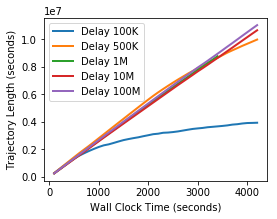

In [55]:
d = "../experiments/baseline-trinitite/"
def plot_times(ax, label, results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label, lw=2)
    ax.set_ylabel("Trajectory Length (seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_times(ax, "Delay 100K", d+"nano/parmsweep/scale-delay-100000-60117")
plot_times(ax, "Delay 500K", d+"nano/scale-delay-500000-60688/")
plot_times(ax, "Delay 1M",   d+"nano/parmsweep/scale-delay-1000000-60120")
plot_times(ax, "Delay 10M",  d+"nano/parmsweep/scale-delay-10000000-60119")
plot_times(ax, "Delay 100M", d+"nano/parmsweep/scale-delay-100000000-60118")

# 2. Stressing the Storage System
- graph shows keyspaces on each rank
- lower delay has bigger keyspace but keys are way colder

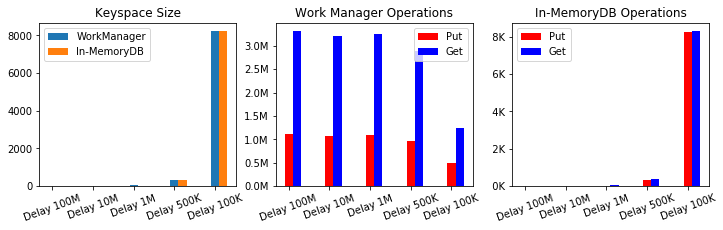

In [54]:
plot_keyspace(["Delay 100M", "Delay 10M", "Delay 1M", "Delay 500K", "Delay 100K"])

**GRAPH BELOW SHOWS**: total number of keys (`y1` axis) vs. number of active keys (`y2` axis)
- unique keys increase over time, throughput of keys goes down

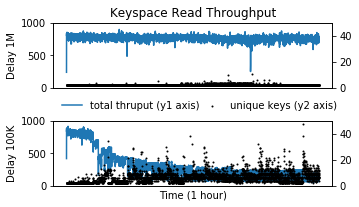

In [22]:
def plot_uniquekeys_per_ts(ax, dfs, key_tuple, ylim=800, shift=0):
    df = dfs[key_tuple]['DF_KEY_TIMES']            # get all timestamps for all keys
    
    df_t = df.groupby('ts').size().reset_index()   # throughput
    df_t.columns=['ts', 'count']
    
    df_u = df.drop_duplicates()                    # only find unique keys by dropping duplicates
    df_u = df_u.groupby('ts').size().reset_index() # for each time stamp, count the unique
    df_u.columns=['ts', 'count']
    
    ax.plot(df_t['ts'], df_t['count'], label="total thruput (y1 axis)")
    ax2 = ax.twinx()
    ax2.scatter(df_u['ts'], df_u['count'], color='black', s=1, label="unique keys (y2 axis)")
    ax.set_ylim(0, 2000)
    ax2.set_ylim(0, 50)
    return ax2

fig, ax = plt.subplots(2, 1, figsize=(5, 3))
fig.subplots_adjust(hspace=.5)
plot_uniquekeys_per_ts(ax[0], dfs, ("Delay 1M", "DBMemoryGet", "4"))
ax2 = plot_uniquekeys_per_ts(ax[1], dfs, ("Delay 100K", "DBMemoryGet", "4"))
ax[0].set_xlabel("")
for i in range(0, len(ax)):
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])
    ax[i].set_ylim(0, 1000)
ax[1].set_xlabel("Time (1 hour)")
ax[1].legend(bbox_to_anchor=(0, 1.45), loc='upper left', frameon=False)
ax2.legend(bbox_to_anchor=(0.5, 1.45), loc='upper left', frameon=False)
ax[0].set_title("Keyspace Read Throughput")
ax[0].set_ylabel("Delay 1M")
x = ax[1].set_ylabel("Delay 100K")

**GRAPH BELOW SHOWS**: which keys are are hot
- smaller delays have more colder keys

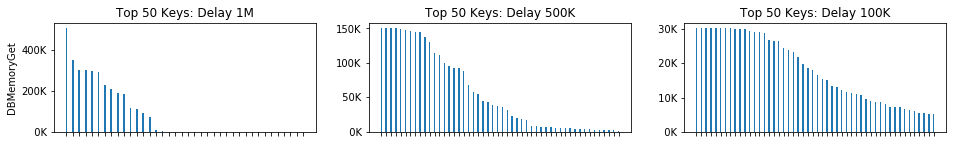

In [57]:
def plot_keyspace(ax, dfs, key, shift=0, nkeys=50):
    # parse and ingest
    dftop = dfs[key]['DF_KEY_COUNT'].nlargest(nkeys, 'count').head(50) # not sure why we need to do head here

    # plot it (break if we don't find any ops)
    if len(dftop) == 0: return -1
    x = np.arange(len(dftop['key']))
    ax.bar(x + shift, dftop['count'], width=0.3, label=names[key[2]])

    # cleanup graphs
    ax.set_xticks(x); ax.set_xticklabels([])
    if np.max(ax.get_yticks()) > 2000:
        ax.set_yticklabels(['{:3.0f}K'.format(x/1000) for x in ax.get_yticks()])
    ax.set_title("Top " + str(nkeys) + " Keys: " + key[0])
    #ax.set_xticklabels(d['key'], rotation=90)

for op in ["DBMemoryGet"]:
    fig, ax = plt.subplots(1, 3, figsize=(16, 2))
    plot_keyspace(ax[0], dfs, ("Delay 1M", op, "4"))
    plot_keyspace(ax[1], dfs, ("Delay 500K", op, "4"))
    plot_keyspace(ax[2], dfs, ("Delay 100K", op, "4"))
    ax[0].set_ylabel(op)

# 3 Key Work Manager Cache

**GRAPHS BELOW SHOW**: limiting the size of the WM cache to 3 keys has no affect
- keyspace isn't big enough to show better memory usage, but shrinking past delay 100K would reduce the amount of "science"
- not seeing the sync problem on puts
- indicates that WM cache is unncessary

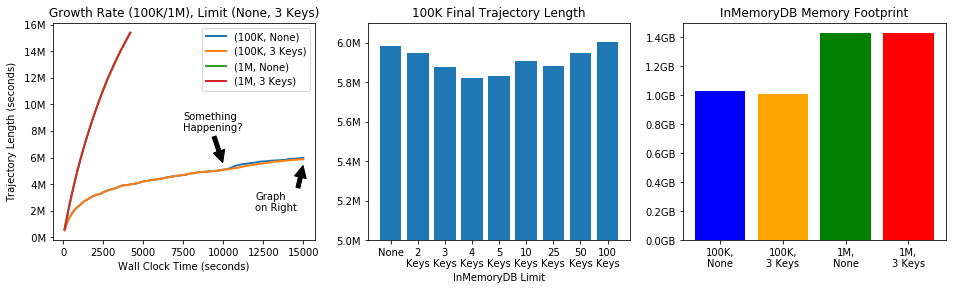

In [45]:
def get_max_traj(results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    return df.tail(1)['traj']

def plot_times(ax, label, results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label, lw=2)
    ax.set_ylabel("Trajectory Length (seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()
    
def get_keyspace(op, results):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf.1", "tmp/perf.1")
    fname = "tmp/perf.1"
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    df_op = df[df['op'] == op]
    shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
    df_op['ts_shift'] = df_op['ts'] - shift
    return df_op[df_op['ts_shift'] == 4100.0]['count']

def get_mem(results):
    fname = ""
    if os.path.exists(results + "/out/mem.out"):
        fname = results + "/out/mem.out"
    else:
        untar(results + "/out/mem.out.tar.gz")
        shutil.move("mem.out", "tmp/mem.out")                
        fname = "tmp/mem.out"

    x = []; y = []; first = -1
    with open(fname) as f:
        for line in f:
            words = line.split(',')
            x.append(int(words[0]))
            y.append(int(' '.join(words[1].split()).split(' ')[2]))
    shift = x[0]*np.ones(len(x))
    return y[len(x) - 1]
    #ax.bar([x[len(x) - 1]], [y[len(x) - 1]], label=label)

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
#fig.subplots_adjust(wspace=0.25)

d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
plot_times(ax[0], "(100K, None)", d+"intpurge-none-69205")
plot_times(ax[0], "(100K, 3 Keys)",    d+"intpurge-3-69193")
d = "../experiments/baseline-trinitite/nano/purge-keys-1hr-delay1M/"
plot_times(ax[0], "(1M, None)",   d+"intpurge-none-69956")
plot_times(ax[0], "(1M, 3 Keys)",      d+"intpurge-3-69959")
ax[0].set_title("Growth Rate (100K/1M), Limit (None, 3 Keys)")
ax[0].set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax[0].get_yticks()])
ax[0].annotate('Something\nHappening?', xy=(10000, 5.5*1000*1000), xytext=(7500, 8*1000*1000),
               arrowprops=dict(facecolor='black', shrink=0.05))
ax[0].annotate('Graph\non Right', xy=(15000, 5.5*1000*1000), xytext=(12000, 2*1000*1000),
               arrowprops=dict(facecolor='black', shrink=0.05))

d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
y = []; labels = []
for run in ["intpurge-none-69205", "intpurge-2-69192", "intpurge-3-69193", "intpurge-4-69194", "intpurge-5-69196", "intpurge-10-69197", "intpurge-25-69199", "intpurge-50-69200", "intpurge-100-69201"]:
    l = run.split('-')[1]
    if l == "none": l = "None"
    else: l = l + "\nKeys"
    labels.append(l)
    y.append(get_max_traj(d+run))
ax[1].set_xticks(range(0, len(y)))
ax[1].set_xticklabels(labels)
ax[1].bar(np.arange(len(y)), y)
ax[1].set_ylim(5000000, 6100000)
ax[1].set_yticklabels(['{:3.1f}M'.format(yval/(1000*1000)) for yval in ax[1].get_yticks()])
ax[1].set_title("100K Final Trajectory Length")
ax[1].set_xlabel("InMemoryDB Limit")

y = []; labels = []
d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
y.append(get_keyspace("DBMemorySize", d+"intpurge-none-69205"))
y.append(get_keyspace("DBMemorySize", d+"intpurge-3-69193"))
labels.append("100K,\nNone")
labels.append("100K,\n3 Keys")
#plot_times(ax[0], "(100K, Unlimited)", d+"intpurge-none-69205")
#plot_times(ax[0], "(100K, 3 Keys)",    d+"intpurge-3-69193")
d = "../experiments/baseline-trinitite/nano/purge-keys-1hr-delay1M/"
y.append(get_keyspace("DBMemorySize", d+"intpurge-none-69956"))
y.append(get_keyspace("DBMemorySize", d+"intpurge-3-69959"))
labels.append("1M,\nNone")
labels.append("1M,\n3 Keys")

ax[2].bar(np.arange(len(y)), y, color=['blue', 'orange', 'green', 'red'])
ax[2].set_xticks(range(0, len(labels)))
ax[2].set_xticklabels(labels)
ax[2].set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax[2].get_yticks()])
x = ax[2].set_title("InMemoryDB Memory Footprint")

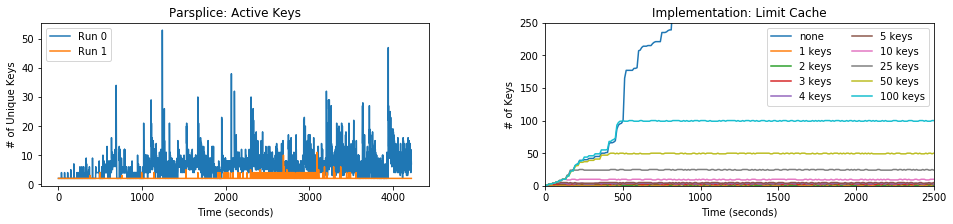

In [48]:
def plot_uniquekeys_per_ts(ax, dfs, key_tuple, label="blah", ylim=800, shift=0):
    df = dfs[key_tuple]['DF_KEY_TIMES']            # get all timestamps for all keys
    
    df_t = df.groupby('ts').size().reset_index()   # throughput
    df_t.columns=['ts', 'count']
    
    df_u = df.drop_duplicates()                    # only find unique keys by dropping duplicates
    df_u = df_u.groupby('ts').size().reset_index() # for each time stamp, count the unique
    df_u.columns=['ts', 'count']
    shift = np.min(df_u['ts']) * np.ones(len(df_u['ts']))
    ax.plot(df_u['ts'] - shift, df_u['count'], label=label)
    ax.set_title("Parsplice: Active Keys")
    ax.set_ylabel("# of Unique Keys")
    ax.set_xlabel("Time (seconds)")
    ax.legend()
    
def plot_keyspace(ax, op, results, rank="1"):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    #ax.set_title("# Keys (y1) vs. Size of Data (y2)")
    df_op = df[df['op'] == op]
    shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
    label = os.path.basename(results).split('-')[1]
    if label != "none":
        label = label + " keys"
    ax.plot(df_op['ts'].astype(float) - shift, df_op['count'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")

fig, ax = plt.subplots(1, 2, figsize=(16, 3))
fig.subplots_adjust(wspace=0.3)
plot_uniquekeys_per_ts(ax[0], dfs, ("Delay 100K", "DBMemoryGet", "4"), "Run 0")
plot_uniquekeys_per_ts(ax[0], dfs, ("Delay 1M",   "DBMemoryGet", "4"), "Run 1")

d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
for run in ["intpurge-none-69205", "intpurge-1-69059", "intpurge-2-69192", "intpurge-3-69193", "intpurge-4-69194", "intpurge-5-69196", "intpurge-10-69197", "intpurge-25-69199", "intpurge-50-69200", "intpurge-100-69201"]:
    plot_keyspace(ax[1], "DBMemoryMapSize", d+run)
ax[1].set_title("Implementation: Limit Cache") 
ax[1].set_ylim(0, 250)
ax[1].set_xlim(0, 2500)
ax[1].legend(ncol=2)
ax[1].set_ylabel("# of Keys")

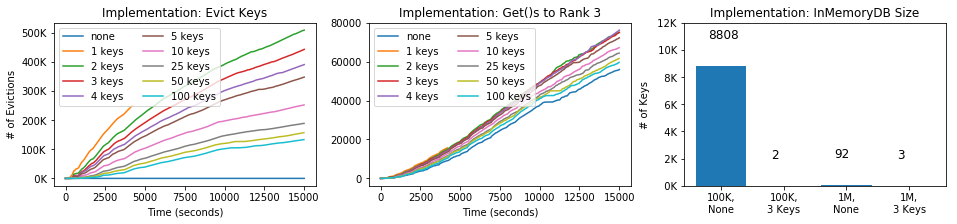

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))

d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
for run in ["intpurge-none-69205", "intpurge-1-69059", "intpurge-2-69192", "intpurge-3-69193", "intpurge-4-69194", "intpurge-5-69196", "intpurge-10-69197", "intpurge-25-69199", "intpurge-50-69200", "intpurge-100-69201"]:
    plot_keyspace(ax[0], "DBMemoryPurge", d+run)
ax[0].set_title("Implementation: Evict Keys")
ax[0].set_ylabel("# of Evictions")
ax[0].set_yticklabels(['{:3.0f}K'.format(yval/(1000)) for yval in ax[0].get_yticks()])
x = ax[0].legend(ncol=2)
 
def get_max_traj(results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    return df.tail(1)['traj']

d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
for run in ["intpurge-none-69205", "intpurge-1-69059", "intpurge-2-69192", "intpurge-3-69193", "intpurge-4-69194", "intpurge-5-69196", "intpurge-10-69197", "intpurge-25-69199", "intpurge-50-69200", "intpurge-100-69201"]:
    plot_keyspace(ax[1], "DBMemoryGet", d+run, rank="3")
ax[1].legend(ncol=2)
ax[1].set_title("Implementation: Get()s to Rank 3")

y = []; labels = []
d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
y.append(get_keyspace("DBMemoryMapSize", d+"intpurge-none-69205"))
y.append(get_keyspace("DBMemoryMapSize", d+"intpurge-3-69193"))
d = "../experiments/baseline-trinitite/nano/purge-keys-1hr-delay1M/"
y.append(get_keyspace("DBMemoryMapSize", d+"intpurge-none-69956"))
y.append(get_keyspace("DBMemoryMapSize", d+"intpurge-3-69959"))
x = np.arange(len(y))
ax[2].bar(x, y)
ax[2].set_ylim(0, 12000)
ax[2].set_xticks(range(0, len(x)))
ax[2].set_xticklabels(["100K,\nNone", "100K,\n3 Keys", "1M,\nNone", "1M,\n3 Keys"])
for i,j in zip(x,y):
    ax[2].annotate(int(j),xy=(i-0.2,int(j)+2000), fontsize=12)
ax[2].set_yticklabels(['{:3.0f}K'.format(yval/(1000)) for yval in ax[2].get_yticks()])
ax[2].set_title("Implementation: InMemoryDB Size")
x = ax[2].set_ylabel("# of Keys")